# Breif of Algorithm

1. Preparing the data
Computing similarity or dissimilarity information between every pair of objects in the data set.


2. Using linkage function to group objects into hierarchical cluster tree, based on the distance information generated at step 1. Objects/clusters that are in close proximity are linked together using the linkage function.


3. Determining where to cut the hierarchical tree into clusters. This creates a partition of the data.

In [2]:
#importing required libraries

import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram,linkage
import pandas as pd

In [3]:
#importing dataSets

irisDataSet=pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data",header=None)
irisDataSet.columns=['Sepal-length(cm)','Sepal-width(cm)','Petal-length(cm)','Petal-width(cm)','Class']

irisData=irisDataSet.iloc[:,0:4].to_numpy()

egDataSet=np.array([
    [5 , 3],
    [10,15],
    [15,12],
    [24,10],
    [30,30],
    [85,70],
    [71,80],
    [60,78],
    [70,55],
    [80,91]
    ])


In [5]:
#defining cluster object

class Cluster(object):
  nodeIds=[]
  centroidNode=None
  def __init__(self,nodeIds,id,centroidNode):
    self.centroidNode=centroidNode
    self.nodeIds=nodeIds
    self.id=id

In [6]:
class HierarchicalClustering(object):

  clusters=[]
  linkageMat=[]
  linkOrder=[]
  linkage=None
  isTest=None
  def __init__(self,dataset,linkage="centroid",isTest=False):
    self.dataSet=dataset
    self.linkage=linkage
    self.linkOrder=[[i] for i in range(len(self.dataSet))]
    self.linkageMat=[]
    self.clusters=[(Cluster([i],i,node))for i,node in enumerate(self.dataSet)]
    self.isTest=isTest

  def agglomerative(self):

    if self.isTest:
      nodes=[]
      for c in self.clusters:
        nodes.append(c.nodeIds)
      print("Initial State of Clusters identified by their index : ",nodes,"\n")


    calculatedDist={}
    
    clusterId=-1
    while len(self.clusters)>1:

      minDist=1e9
      minDistPairIds=(-1,-1)

      for i in range(len(self.clusters)):
        for j in range(i+1,len(self.clusters)):

          if (self.clusters[i].id,self.clusters[j].id) not in calculatedDist:

            if self.linkage=="centroid":
              calculatedDist[(self.clusters[i].id,self.clusters[j].id)]=self.centroidLinkage(self.clusters[i],self.clusters[j])
            if self.linkage=="single":
              calculatedDist[(self.clusters[i].id,self.clusters[j].id)]=self.minDistLinkage(self.clusters[i],self.clusters[j],calculatedDist)
            if self.linkage=="complete":
              calculatedDist[(self.clusters[i].id,self.clusters[j].id)]=self.maxDistLinkage(self.clusters[i],self.clusters[j],calculatedDist)          
            if self.linkage=="average":
              calculatedDist[(self.clusters[i].id,self.clusters[j].id)]=self.avgDistLinkage(self.clusters[i],self.clusters[j],calculatedDist)


          if calculatedDist[(self.clusters[i].id,self.clusters[j].id)] < minDist:

            minDist=calculatedDist[(self.clusters[i].id,self.clusters[j].id)]
            minDistPairIds=(i,j)


      self.entryIntoLinkageMat(minDistPairIds[0],minDistPairIds[1],minDist)
      self.linkOrder.append(self.clusters[minDistPairIds[0]].nodeIds+self.clusters[minDistPairIds[1]].nodeIds)

      centroidNode=self.centroid(self.clusters[minDistPairIds[0]],self.clusters[minDistPairIds[1]])

      newCluster=Cluster(self.clusters[minDistPairIds[0]].nodeIds+self.clusters[minDistPairIds[1]].nodeIds,clusterId,centroidNode)

      if self.isTest:
        print("\n------------------------------------------------")
        nodes=[]
        for c in self.clusters:
          nodes.append(c.nodeIds)
        print("State of clusters before merging : ",nodes)
        print("\nClusters selected for merging : ",self.clusters[minDistPairIds[0]].nodeIds," , ",self.clusters[minDistPairIds[1]].nodeIds)
        print("Distance between them : ",minDist)
        print("Cluster after merging them : ",self.clusters[minDistPairIds[0]].nodeIds+self.clusters[minDistPairIds[1]].nodeIds)

      clusterId-=1
      del self.clusters[minDistPairIds[1]]
      del self.clusters[minDistPairIds[0]]
      self.clusters.append(newCluster)

      if self.isTest:
        nodes=[]
        for c in self.clusters:
          nodes.append(c.nodeIds)
        print("\nState of clusters after the merge : ",nodes)
        print("------------------------------------------------\n")
      
          

  def euclideanDist(self,node1,node2):
	  return np.sqrt(sum((node1-node2) ** 2))
   
  def entryIntoLinkageMat(self,indx1,indx2,dist):
    temp=[]
    for i in range(len(self.linkOrder)):
      if self.linkOrder[i]==self.clusters[indx1].nodeIds:
        temp.append(i)
        break

    for i in range(len(self.linkOrder)):
      if self.linkOrder[i]==self.clusters[indx2].nodeIds:
        temp.append(i)
        break

    temp.append(dist)
    temp.append(len(self.clusters[indx1].nodeIds)+len(self.clusters[indx2].nodeIds))

    self.linkageMat.append(temp)


  def centroid(self,cluster1,cluster2):
    nodes=len(cluster1.nodeIds)*np.array(cluster1.centroidNode)+len(cluster2.nodeIds)*np.array(cluster2.centroidNode) 
    centroid = nodes/(len(cluster1.nodeIds)+len(cluster2.nodeIds))
    return centroid

  
  #linkage functions

  #centroid linking function

  def centroidLinkage(self,cluster1,cluster2):
    return self.euclideanDist(cluster1.centroidNode,cluster2.centroidNode)


  #simple linking function
  def minDistLinkage(self,cluster1,cluster2,distCache):

    minD=1e9

    for i in cluster1.nodeIds:
      for j in cluster2.nodeIds:
        if (i,j) in distCache:
          d=distCache[(i,j)]
        elif (j,i) in distCache:
          d=distCache[(j,i)]
        else:
          d=self.euclideanDist(cluster1.centroidNode,cluster2.centroidNode)
        
        if d<minD:
          minD=d
    return minD
  

  #complete linking function

  def maxDistLinkage(self,cluster1,cluster2,distCache):

    maxD=-1e9

    for i in cluster1.nodeIds:
      for j in cluster2.nodeIds:
        if (i,j) in distCache:
          d=distCache[(i,j)]
        elif (j,i) in distCache:
          d=distCache[(j,i)]
        else:
          d=self.euclideanDist(cluster1.centroidNode,cluster2.centroidNode)
        
        if d>maxD:
          maxD=d

    return maxD 
    
  #average linking function
  def avgDistLinkage(self,cluster1,cluster2,distCache):

    avgD=0

    for i in cluster1.nodeIds:
      for j in cluster2.nodeIds:
        if (i,j) in distCache:
          avgD+=distCache[(i,j)]
        elif (j,i) in distCache:
          avgD+=distCache[(j,i)]
        else:
          avgD+=self.euclideanDist(self.dataSet[i],self.dataSet[j])

    avgD/=(len(cluster1.nodeIds)*len(cluster2.nodeIds))

    return avgD


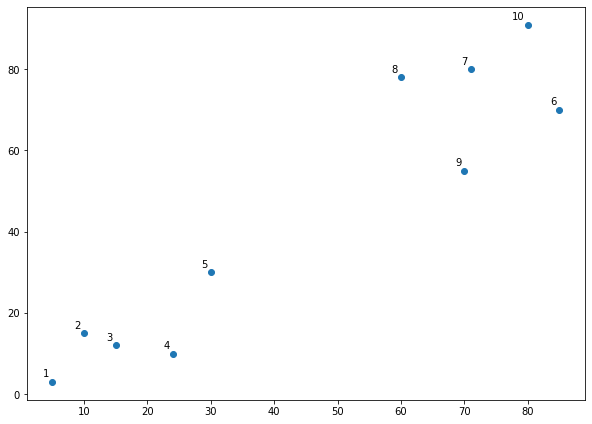

In [8]:
#plotting example dataset
labels = range(1, 11)
plt.figure(figsize=(10, 7))
plt.subplots_adjust(bottom=0.1)
plt.scatter(egDataSet[:,0], egDataSet[:,1], label='True Position')

for label, x, y in zip(labels, egDataSet[:, 0], egDataSet[:, 1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-3, 3),
        textcoords='offset points', ha='right', va='bottom')
plt.show()

Initial State of Clusters identified by their index :  [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9]] 


------------------------------------------------
State of clusters before merging :  [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9]]

Clusters selected for merging :  [1]  ,  [2]
Distance between them :  5.830951894845301
Cluster after merging them :  [1, 2]

State of clusters after the merge :  [[0], [3], [4], [5], [6], [7], [8], [9], [1, 2]]
------------------------------------------------


------------------------------------------------
State of clusters before merging :  [[0], [3], [4], [5], [6], [7], [8], [9], [1, 2]]

Clusters selected for merging :  [6]  ,  [7]
Distance between them :  11.180339887498949
Cluster after merging them :  [6, 7]

State of clusters after the merge :  [[0], [3], [4], [5], [8], [9], [1, 2], [6, 7]]
------------------------------------------------


------------------------------------------------
State of clusters before merging :  [[0], [3]

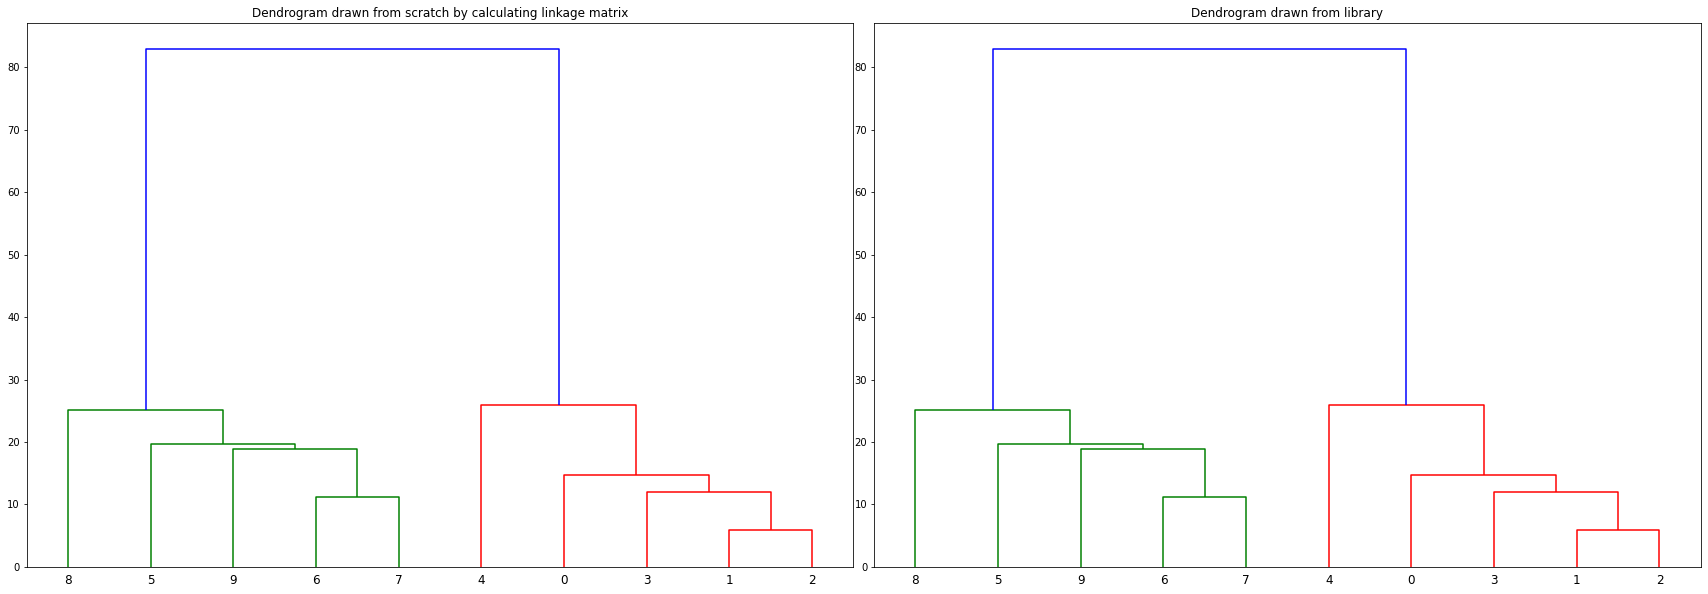

In [9]:
#evaluating clustering algorithm on small dataset for centroid linkage

hcTest=HierarchicalClustering(egDataSet,isTest=True)
hcTest.agglomerative()


fig,ax=plt.subplots(1,2,figsize=(30,10))

Xtest=np.array(hcTest.linkageMat).astype(float)
dn1 = dendrogram(Xtest,ax=ax[0])
ax[0].set_title("Dendrogram drawn from scratch by calculating linkage matrix")

K = linkage(egDataSet,method="centroid")
dn2 = dendrogram(K,ax=ax[1])
ax[1].set_title("Dendrogram drawn from library")

plt.subplots_adjust(wspace=0.025)

print("Comparing Dendrograms :-")

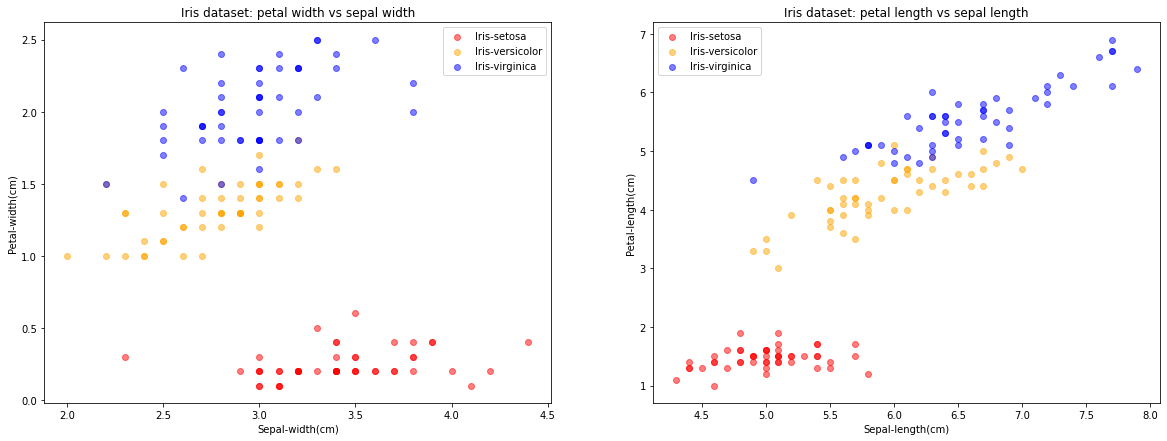

In [ ]:
#visualizing the selected dataSet


colours = ['red', 'orange', 'blue']
species = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']

fig,ax=plt.subplots(1,2,figsize=(20, 7))

for i in range(0, 3):
  classDF = irisDataSet[irisDataSet['Class'] == species[i]]  
  ax[0].scatter(        
        classDF['Sepal-width(cm)'],        
        classDF['Petal-width(cm)'],
        color=colours[i],        
        alpha=0.5,        
        label=species[i] ,
         
    )

ax[0].set_xlabel('Sepal-width(cm)')
ax[0].set_ylabel('Petal-width(cm)')
ax[0].set_title('Iris dataset: petal width vs sepal width')
ax[0].legend()


for i in range(0, 3):
  classDF = irisDataSet[irisDataSet['Class'] == species[i]]  
  ax[1].scatter(        
        classDF['Sepal-length(cm)'],        
        classDF['Petal-length(cm)'],
        color=colours[i],        
        alpha=0.5,        
        label=species[i] ,
         
    )
ax[1].set_xlabel('Sepal-length(cm)')
ax[1].set_ylabel('Petal-length(cm)')
ax[1].set_title('Iris dataset: petal length vs sepal length')
ax[1].legend()


fig.show()


In [11]:
hcCentroid=HierarchicalClustering(irisData)

hcCentroid.agglomerative()


Comparing Dendrograms for Centroid Linkage :-


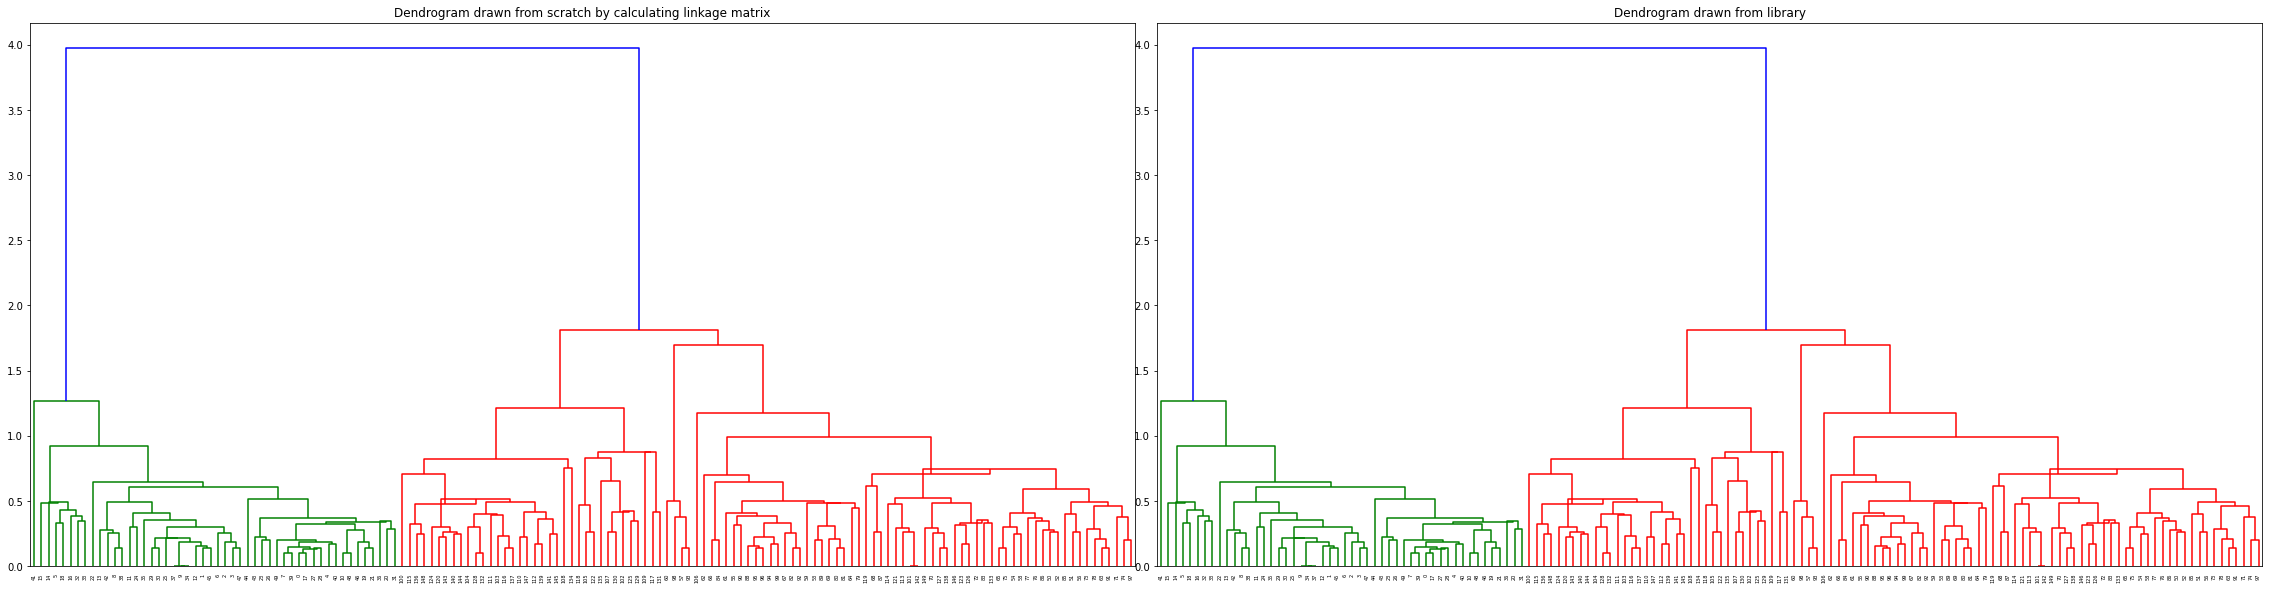

In [12]:
fig,ax=plt.subplots(1,2,figsize=(40,10))


Xcentroid = np.array(hcCentroid.linkageMat).astype(float)
dn1 = dendrogram(Xcentroid,ax=ax[0])
ax[0].set_title("Dendrogram drawn from scratch by calculating linkage matrix")


K = linkage(irisData,method="centroid")
dn2 = dendrogram(K,ax=ax[1])
ax[1].set_title("Dendrogram drawn from library")

plt.subplots_adjust(wspace=0.02)

print("Comparing Dendrograms for Centroid Linkage :-")

In [13]:
hcSimple=HierarchicalClustering(irisData,linkage="single")

hcSimple.agglomerative()


Comparing Dendrograms for Single Linkage :-


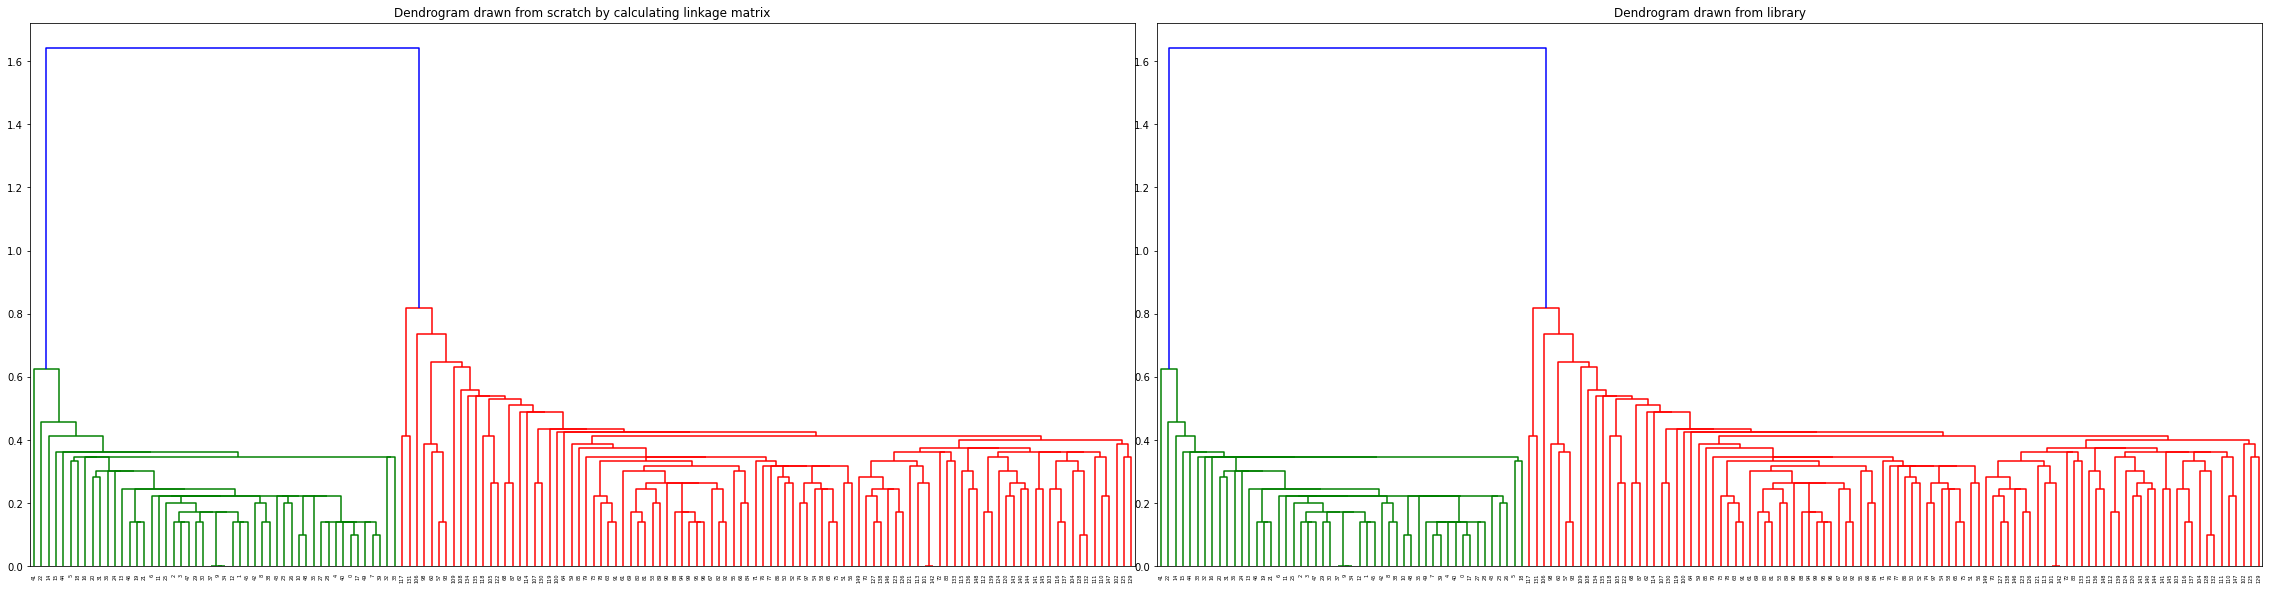

In [15]:
fig,ax=plt.subplots(1,2,figsize=(40,10))


Xsimple=np.array(hcSimple.linkageMat).astype(float)
dn1 = dendrogram(Xsimple,ax=ax[0])
ax[0].set_title("Dendrogram drawn from scratch by calculating linkage matrix")


K = linkage(irisData,method="single")
dn2 = dendrogram(K,ax=ax[1])
ax[1].set_title("Dendrogram drawn from library")

plt.subplots_adjust(wspace=0.02)

print("Comparing Dendrograms for Single Linkage :-")

In [16]:
hcComplete=HierarchicalClustering(irisData,linkage="complete")

hcComplete.agglomerative()


Comparing Dendrograms for Complete Linkage :-


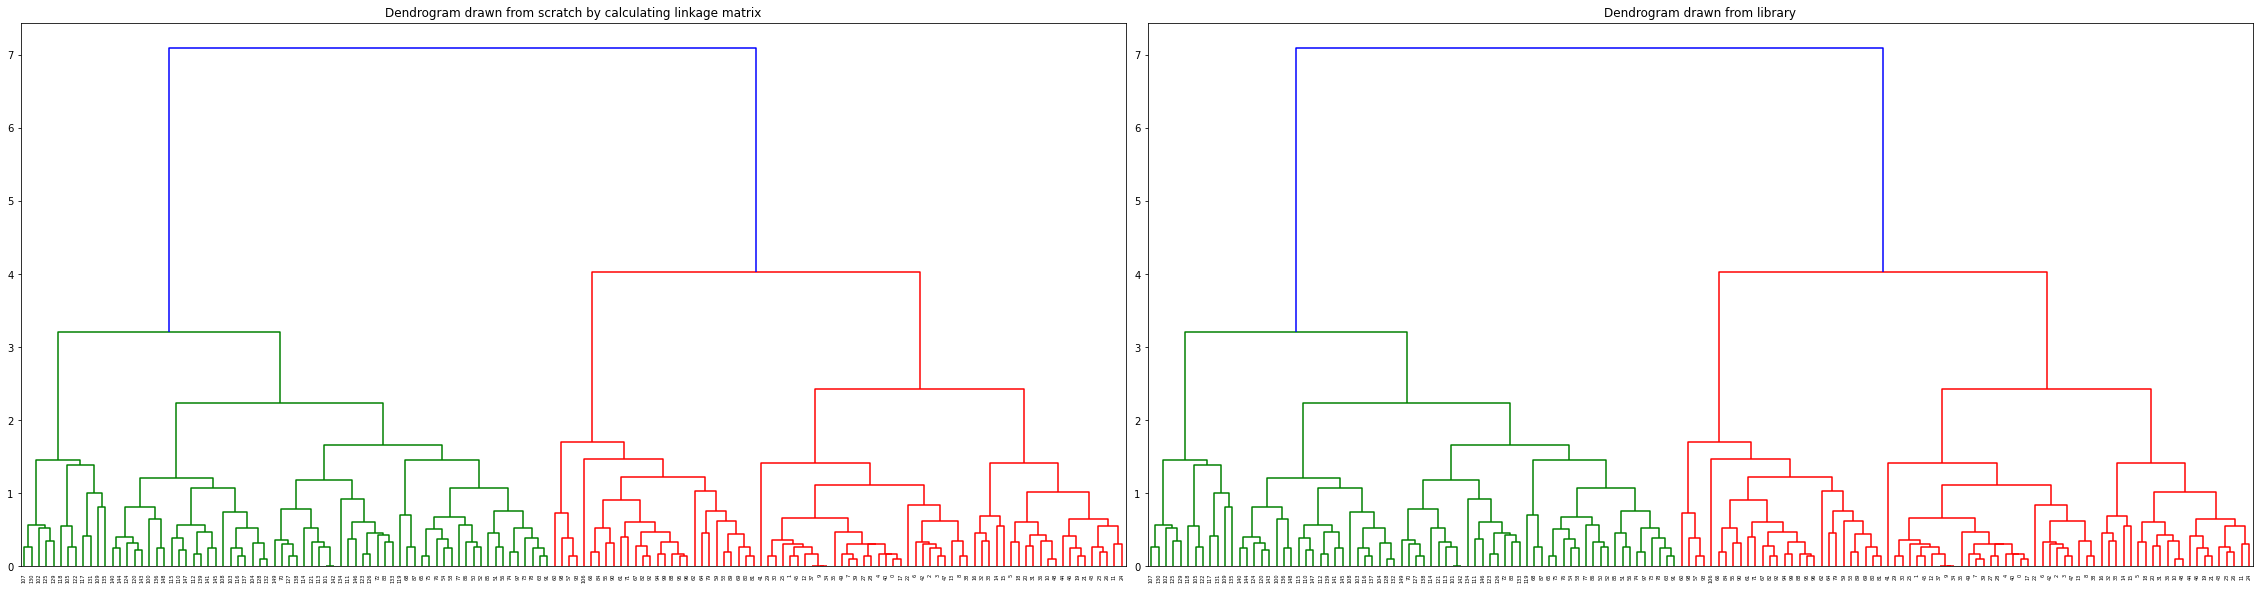

In [17]:
fig,ax=plt.subplots(1,2,figsize=(40,10))


Xcomplete=np.array(hcComplete.linkageMat).astype(float)
dn1 = dendrogram(Xcomplete,ax=ax[0])
ax[0].set_title("Dendrogram drawn from scratch by calculating linkage matrix")


K = linkage(irisData,method="complete")
dn2 = dendrogram(K,ax=ax[1])
ax[1].set_title("Dendrogram drawn from library")

plt.subplots_adjust(wspace=0.02)

print("Comparing Dendrograms for Complete Linkage :-")

In [18]:
hcAvg=HierarchicalClustering(irisData,linkage="average")

hcAvg.agglomerative()


Comparing Dendrograms for Average Linkage :-


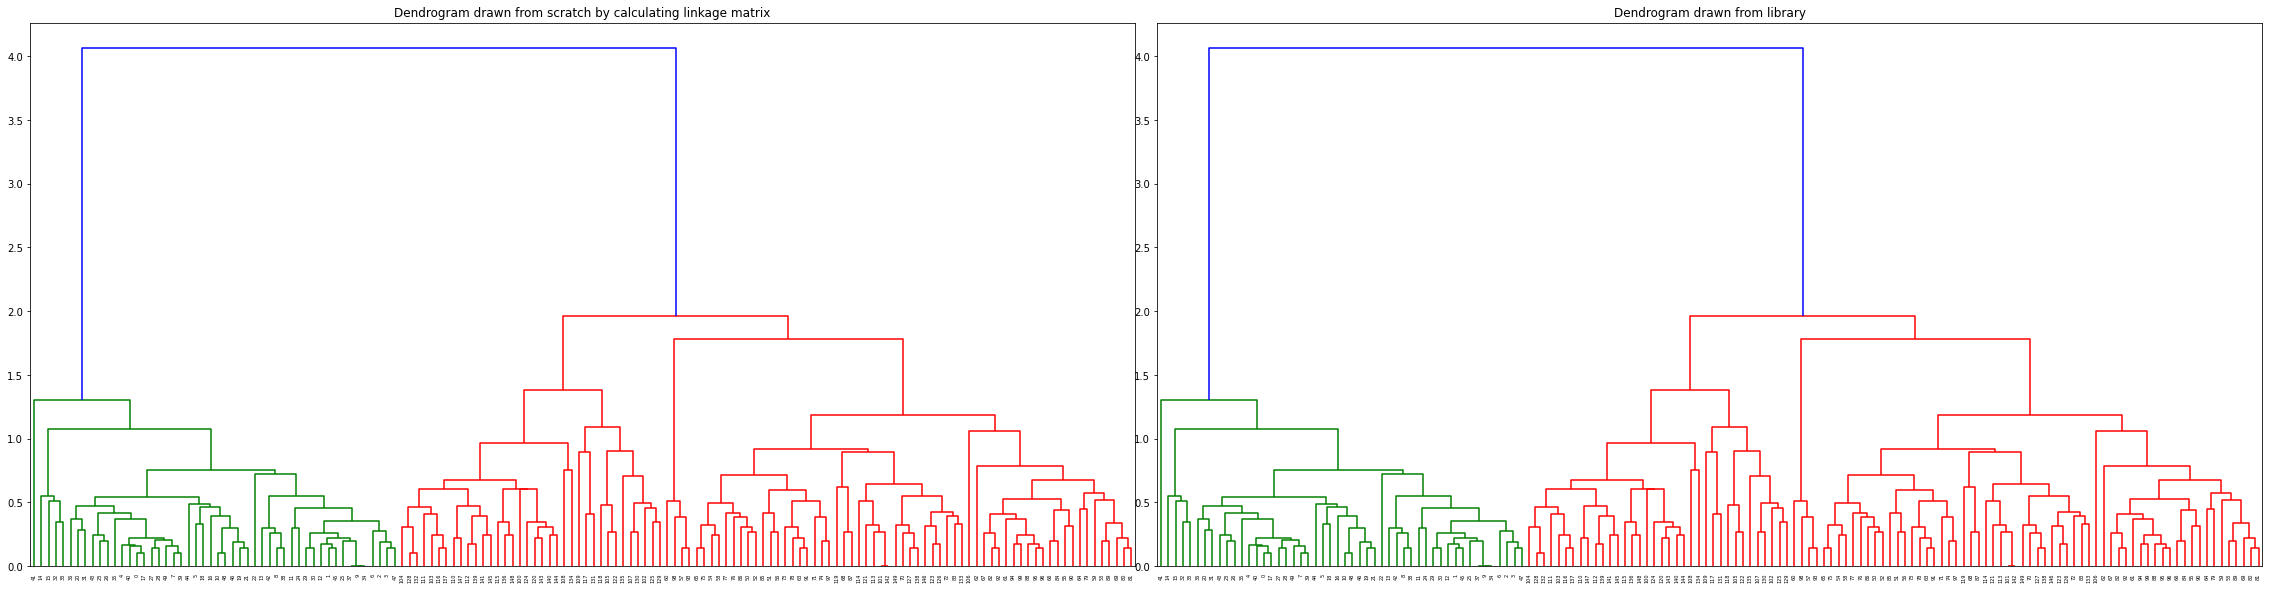

In [19]:
fig,ax=plt.subplots(1,2,figsize=(40,10))


Xavg=np.array(hcAvg.linkageMat).astype(float)
dn1 = dendrogram(Xavg,ax=ax[0])
ax[0].set_title("Dendrogram drawn from scratch by calculating linkage matrix")


K = linkage(irisData,method="average")
dn2 = dendrogram(K,ax=ax[1])
ax[1].set_title("Dendrogram drawn from library")

plt.subplots_adjust(wspace=0.02)

print("Comparing Dendrograms for Average Linkage :-")